# Predicting Color Classes from 2D Coordinates Using a Neural Network

## Project Steps

-   **Data Preparation**: Create arrays of 2D coordinates (`x`, `y`) and
    corresponding color labels, and split data into training and test
    sets.
-   **Model Creation**: Use PyTorch to create a neural network for
    multi-class classification.
-   **Training**: Train the model for multiple epochs.
-   **Evaluation**: Evaluate the model using the test data and predict
    color classes.
-   **Visualization**: Generate a grid of points, predict color classes,
    and create a scatter plot to visualize the results.

This project demonstrates 2D spatial classification using a neural
network in PyTorch.

In [1]:
import torch
from matplotlib import pyplot
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from typing import Sized, cast
torch.__version__

'2.9.1+cu128'

## Data Generation

In [2]:
color_map = ["red", "blue", "green"]

num_points = 3000
square_size = 800
x = torch.rand(num_points) * square_size
y = torch.rand(num_points) * square_size
color_indices = torch.randint(0, len(color_map), (num_points,))
x -= square_size / 2
y -= square_size / 2
colors = []


def prob_fn(val, zero_val):
    return val * (-1 / zero_val) + 1


for i in range(num_points):
    x0 = x[i]
    y0 = y[i]
    rand = torch.rand(1).item()

    origin_dist = torch.hypot(x0, y0)
    circle_start = 300
    if origin_dist > circle_start and rand > prob_fn(origin_dist - circle_start, 100) and not (x0 > 0 and y0 < 0):
        colors.append(2)
        continue

    eval_f = x0 * x0 / 100
    dist = abs(eval_f - y0)

    if rand > prob_fn(dist, 130):
        colors.append(0)
    else:
        colors.append(1)

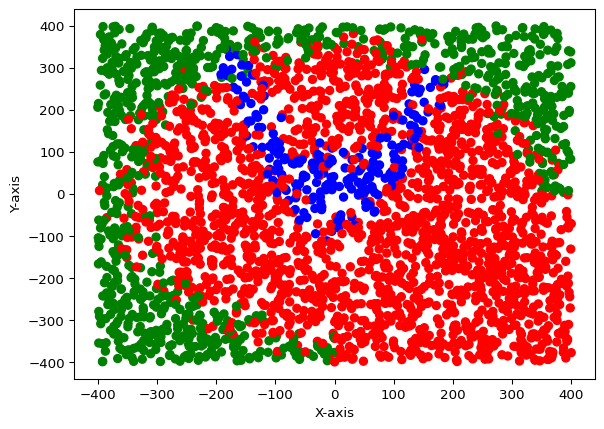

In [3]:
pyplot.scatter(x, y, c=[color_map[i] for i in colors])
pyplot.xlabel("X-axis")
pyplot.ylabel("Y-axis")
pyplot.show()

In [4]:
X = torch.stack((x, y), dim=1)
print(X)

tensor([[-242.4747, -321.7073],
        [ 393.0929, -346.0521],
        [-308.5137, -184.8714],
        ...,
        [  14.1630,  396.8961],
        [-127.4484,  140.0313],
        [  77.9235,  133.3906]])

In [5]:
y_labels = torch.tensor(colors)

print(y_labels, Counter(y_labels.tolist()))

tensor([2, 0, 2,  ..., 2, 0, 1]) Counter({0: 1885, 2: 901, 1: 214})

## Model Creation

In [6]:
class ColorPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ColorPredictionModel, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)
        return x

## Training

In [7]:
def split_data(X, y_labels):
    indices = torch.randperm(X.size(0))
    train_size = int(0.8 * X.size(0))

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    return X[train_indices], X[test_indices], y_labels[train_indices], y_labels[test_indices]


X_train, X_test, y_train, y_test = split_data(X, y_labels)

In [8]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = ColorPredictionModel(input_size=2, hidden_size=40, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)

    if (epoch + 1) % 10 == 0:
        loss = running_loss / len(cast(Sized, train_loader.dataset))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")

Epoch [10/100], Loss: 0.5645
Epoch [20/100], Loss: 0.5210
Epoch [30/100], Loss: 0.4189
Epoch [40/100], Loss: 0.3690
Epoch [50/100], Loss: 0.3331
Epoch [60/100], Loss: 0.3060
Epoch [70/100], Loss: 0.2793
Epoch [80/100], Loss: 0.2648
Epoch [90/100], Loss: 0.2605
Epoch [100/100], Loss: 0.2472

## Model Testing and Visualization

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

Accuracy on test data: 91.67%

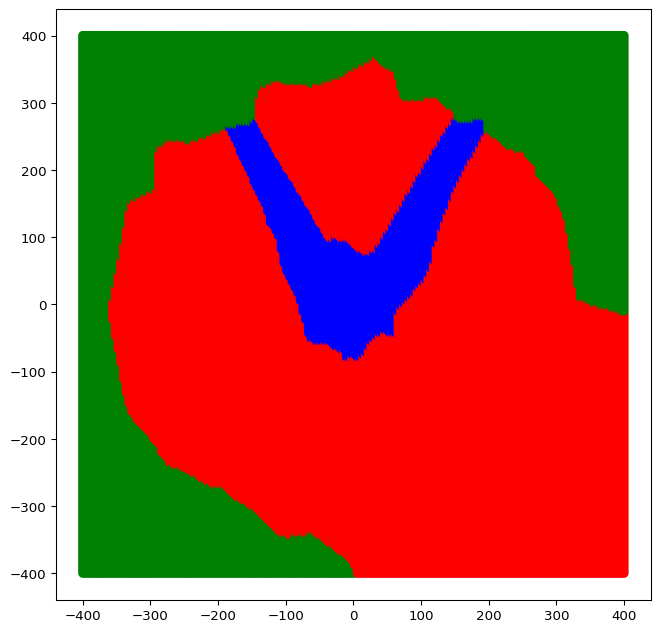

In [10]:
x_range = torch.linspace(-400, 400, 200)
y_range = torch.linspace(-400, 400, 200)

x_grid, y_grid = torch.meshgrid(x_range, y_range, indexing="ij")

grid_points = torch.stack([x_grid.flatten(), y_grid.flatten()], dim=1)

model.eval()

with torch.no_grad():
    outputs = model(grid_points)
    predicted_classes = torch.argmax(outputs, dim=1)

pyplot.figure(figsize=(8, 8))
pyplot.scatter(x_grid, y_grid, c=[color_map[i] for i in predicted_classes])
pyplot.show()